# Ultrasonic distance sensor analysis

Reusable functions for raw/cleaned histograms, per-trial stats, and expected vs actual distance plots with error bars and best-fit lines. All functions take pandas DataFrames (e.g. from your CSV data).

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
import numpy as np

In [25]:
def get_stats(df, register=None):
    """
    Compute per-trial summary stats from raw sensor data.
    
    Parameters
    ----------
    df : pd.DataFrame
        Must have columns: trial, register, rdistance, strength, edistance.
    register : int or None
        If given, filter to this register only; otherwise use all rows.
    
    Returns
    -------
    pd.DataFrame with columns: trial, expected_distance, median_distance, mean_distance,
    std_distance, median_error, mean_error, count, mean_strength, median_strength.
    """
    work = df.copy()
    if register is not None:
        work = work[work["register"] == register].copy()
    work["error_mm"] = work["rdistance"] - work["edistance"]
    work["abs_strength"] = work["strength"].abs()
    stats = (
        work.groupby("trial")
        .agg(
            expected_distance=("edistance", "median"),
            median_distance=("rdistance", "median"),
            mean_distance=("rdistance", "mean"),
            std_distance=("rdistance", "std"),
            median_error=("error_mm", "median"),
            mean_error=("error_mm", "mean"),
            count=("rdistance", "size"),
            mean_strength=("abs_strength", "mean"),
            median_strength=("abs_strength", "median"),
        )
        .reset_index()
    )
    return stats


def remove_outliers_per_trial(df, value_col="rdistance", trial_col="trial", n_std=2.0):
    """
    Return a copy of df with rows removed where value_col is more than n_std
    standard deviations from the trial median.
    """
    def keep_inliers(g):
        med = g[value_col].median()
        std = g[value_col].std()
        if std == 0 or pd.isna(std):
            return g
        return g[abs(g[value_col] - med) <= n_std * std]

    return (
        df.groupby(trial_col, group_keys=False)
        .apply(keep_inliers)
        .reset_index(drop=True)
    )

In [26]:
def plot_histogram_raw(df, value_col="rdistance", register=None, bins=30, title=None, ax=None):
    """
    Plot histogram of raw values (e.g. rdistance or error).
    
    Parameters
    ----------
    df : pd.DataFrame with trial, register, rdistance, edistance.
    value_col : str
        Column to histogram (e.g. 'rdistance', or use a precomputed 'error_mm' column).
    register : int or None
        If given, filter to this register before plotting.
    bins, title, ax : optional.
    """
    data = df.copy()
    if register is not None:
        data = data[data["register"] == register]
    if value_col == "error_mm" and "error_mm" not in data.columns:
        data["error_mm"] = data["rdistance"] - data["edistance"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(data[value_col].dropna(), bins=bins, edgecolor="black", alpha=0.7)
    ax.set_xlabel(value_col)
    ax.set_ylabel("Count")
    ax.set_title(title or f"Raw {value_col}")
    plt.tight_layout()
    return ax


def plot_histogram_cleaned(df, value_col="rdistance", trial_col="trial", n_std=2.0, register=None, bins=30, title=None, ax=None):
    """
    Plot histogram after removing per-trial outliers.
    """
    data = df.copy()
    if register is not None:
        data = data[data["register"] == register]
    cleaned = remove_outliers_per_trial(data, value_col=value_col, trial_col=trial_col, n_std=n_std)
    if value_col == "error_mm" and "error_mm" not in cleaned.columns:
        cleaned["error_mm"] = cleaned["rdistance"] - cleaned["edistance"]
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(cleaned[value_col].dropna(), bins=bins, edgecolor="black", alpha=0.7, color="green")
    ax.set_xlabel(value_col)
    ax.set_ylabel("Count")
    ax.set_title(title or f"Cleaned {value_col} (n_std={n_std})")
    plt.tight_layout()
    return ax

In [27]:
def plot_expected_vs_actual(
    df_or_stats,
    x_col="expected_distance",
    y_col="median_distance",
    y_err_col="std_distance",
    add_best_fit=True,
    figsize=(7, 5),
    title="Expected vs reported distance",
    ax=None,
):
    """
    Plot expected distance (x) vs actual median/mean distance (y) with error bars and optional best-fit line.
    
    Parameters
    ----------
    df_or_stats : pd.DataFrame
        Either raw sensor df (will call get_stats with register=0) or a stats DataFrame
        from get_stats() with columns expected_distance, median_distance, mean_distance, std_distance.
    x_col, y_col : str
        Column names for x and y (e.g. expected_distance, median_distance or mean_distance).
    y_err_col : str or None
        Column for error bar half-lengths (e.g. std_distance). Set None to skip error bars.
    add_best_fit : bool
        If True, plot linear regression and report slope, intercept, R².
    """
    if "expected_distance" in df_or_stats.columns and "median_distance" in df_or_stats.columns:
        stats = df_or_stats
    else:
        stats = get_stats(df_or_stats, register=0)
    
    stats = stats.dropna(subset=[x_col, y_col])
    x = stats[x_col].values
    y = stats[y_col].values
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    if y_err_col and y_err_col in stats.columns:
        err = stats[y_err_col].fillna(0).values
        ax.errorbar(x, y, yerr=err, fmt="o", capsize=4, capthick=1.5, label="Data")
    else:
        ax.scatter(x, y, label="Data")
    
    if add_best_fit and len(x) >= 2:
        slope, intercept, r, p, se = linregress(x, y)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, slope * x_line + intercept, "r-", lw=2, label=f"Best fit (R²={r**2:.3f})")
        ax.legend()
    
    ax.set_xlabel(x_col + " (mm)")
    ax.set_ylabel(y_col + " (mm)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return ax


def plot_expected_vs_actual_from_cleaned(
    df, register=0, n_std=2.0, use_mean=False, figsize=(7, 5), title=None
):
    """
    Remove outliers per trial, then compute stats and plot expected vs actual with error bars and best fit.
    """
    cleaned = remove_outliers_per_trial(df[df["register"] == register].copy(), value_col="rdistance", n_std=n_std)
    stats = get_stats(cleaned, register=None)
    y_col = "mean_distance" if use_mean else "median_distance"
    return plot_expected_vs_actual(
        stats, y_col=y_col, y_err_col="std_distance",
        figsize=figsize, title=title or f"Expected vs actual (cleaned, n_std={n_std})"
    )


def regression_stats(df_or_stats, x_col="expected_distance", y_col="median_distance"):
    """Return slope, intercept, R² for expected vs y. Pass raw df (register=0) or stats DataFrame."""
    if "expected_distance" in df_or_stats.columns and "median_distance" in df_or_stats.columns:
        s = df_or_stats.dropna(subset=[x_col, y_col])
    else:
        s = get_stats(df_or_stats, register=0).dropna(subset=[x_col, y_col])
    if len(s) < 2:
        return None
    slope, intercept, r, p, se = linregress(s[x_col], s[y_col])
    return {"slope": slope, "intercept": intercept, "r_squared": r**2}

## Data for XM125 back sensor 

- (non-teensy side) running Distance I2C service with 4mm intervals on 7cm to 10cm distance

In [28]:
# Load data (use a path relative to your project or pass a DataFrame)
DATA_DIR = "../data"  # relative to scripts/
df = pd.read_csv(f"{DATA_DIR}/distance_back_pvc_7-10-4.csv")
df_reg0 = df[df["register"] == 0].copy()
df_reg0["error_mm"] = df_reg0["rdistance"] - df_reg0["edistance"]

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


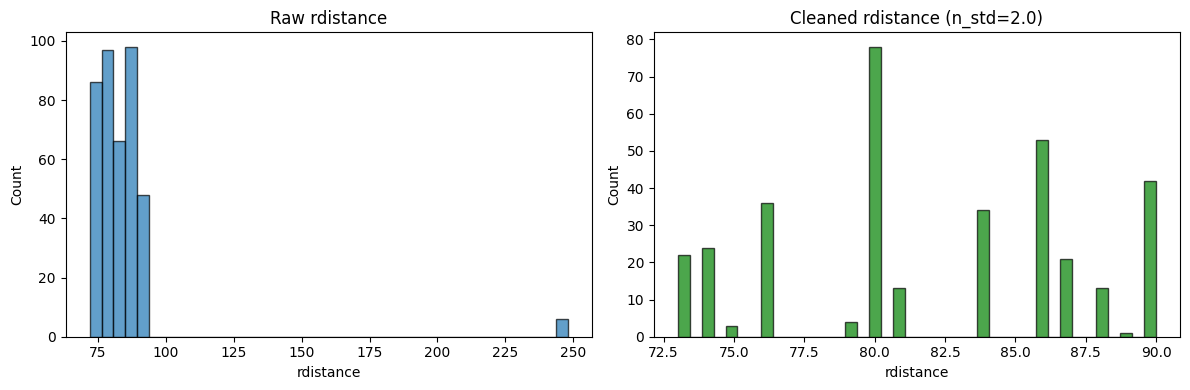

In [29]:
# Histograms: raw and cleaned rdistance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_reg0, value_col="rdistance", bins=40, ax=axes[0])
plot_histogram_cleaned(df_reg0, value_col="rdistance", n_std=2.0, bins=40, ax=axes[1])
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


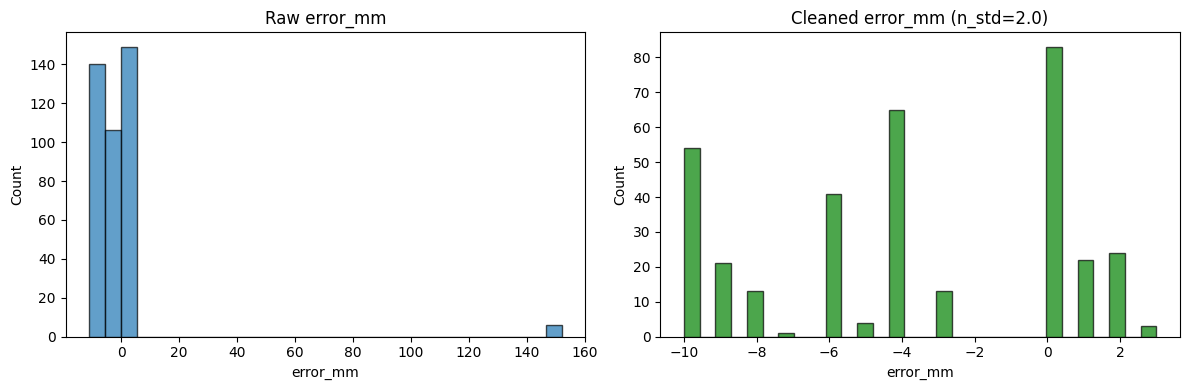

In [30]:
# Histograms: raw and cleaned error
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_reg0, value_col="error_mm", bins=30, ax=axes[0])
plot_histogram_cleaned(df_reg0, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1])
plt.show()

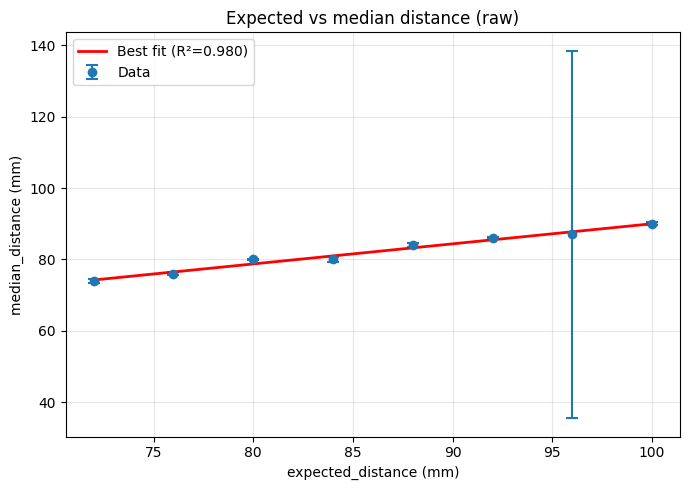

In [31]:
# Expected vs actual from raw stats (no outlier removal)
stats = get_stats(df, register=0)
plot_expected_vs_actual(stats, y_col="median_distance", y_err_col="std_distance", title="Expected vs median distance (raw)")
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


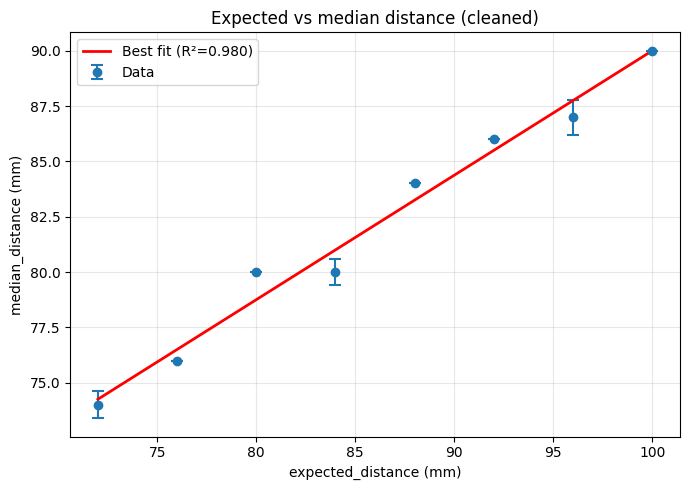

In [32]:
# Expected vs actual from cleaned data (outliers removed per trial)
plot_expected_vs_actual_from_cleaned(df, register=0, n_std=2.0, title="Expected vs median distance (cleaned)")
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


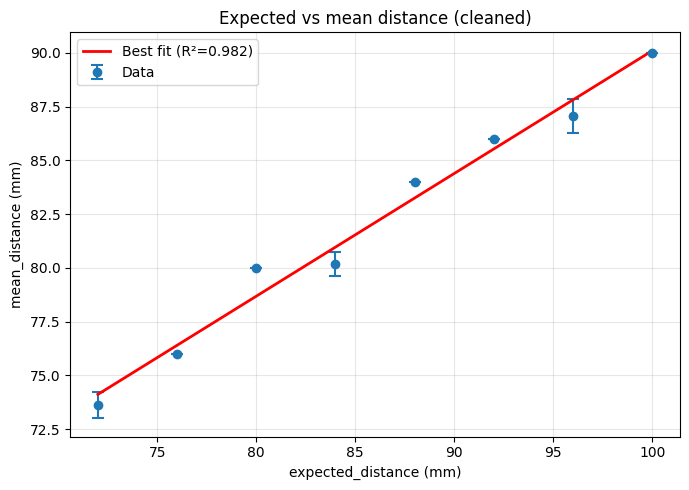

In [33]:
# Same with mean instead of median
plot_expected_vs_actual_from_cleaned(df, register=0, n_std=2.0, use_mean=True, title="Expected vs mean distance (cleaned)")
plt.show()

In [34]:
# Regression stats (slope, intercept, R²) for characterization
stats_raw = get_stats(df, register=0)
stats_cleaned = get_stats(remove_outliers_per_trial(df[df["register"] == 0], n_std=2.0), register=None)
for name, s in [("raw", stats_raw), ("cleaned", stats_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"{name}: slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

raw: slope=0.562, intercept=33.750, R²=0.980
cleaned: slope=0.562, intercept=33.750, R²=0.980


C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


## Error modeling (êᵢ = mean error per trial)

Model error by taking **êᵢ** (e_i hat) as the average difference between measurements and expected distance for each trial. Below: scatter plots (error vs expected distance), parametric linear bias and linear std noise models, and residual visualization.

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


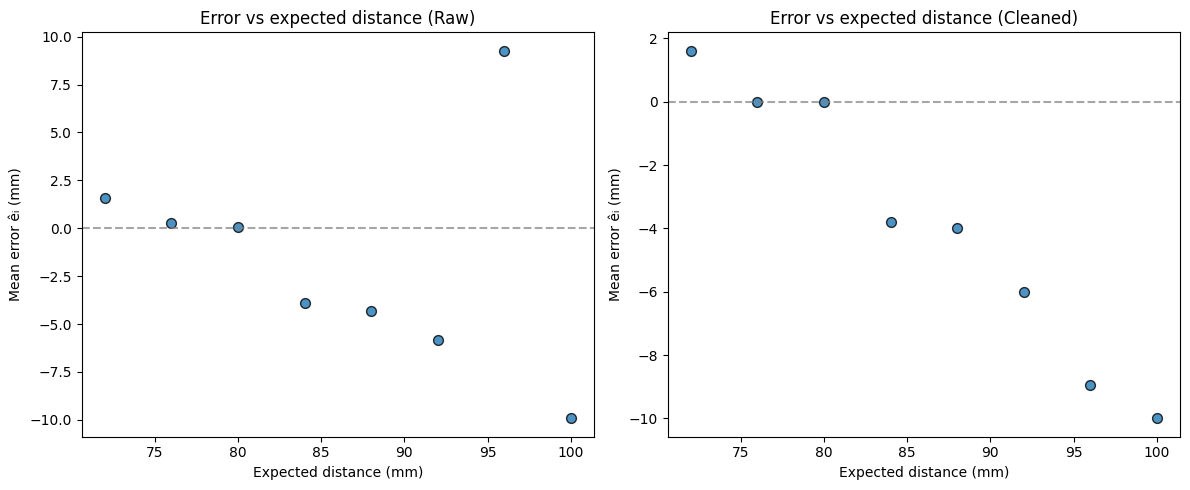

In [35]:
# Scatter: error (êᵢ = mean_error per trial) vs expected distance
stats_err = get_stats(df, register=0)
stats_err_cleaned = get_stats(remove_outliers_per_trial(df[df["register"] == 0], n_std=2.0), register=None)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, s, label in [(axes[0], stats_err, "Raw"), (axes[1], stats_err_cleaned, "Cleaned")]:
    ax.scatter(s["expected_distance"], s["mean_error"], alpha=0.8, edgecolors="k", s=50)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error êᵢ (mm)")
    ax.set_title(f"Error vs expected distance ({label})")
plt.tight_layout()
plt.show()

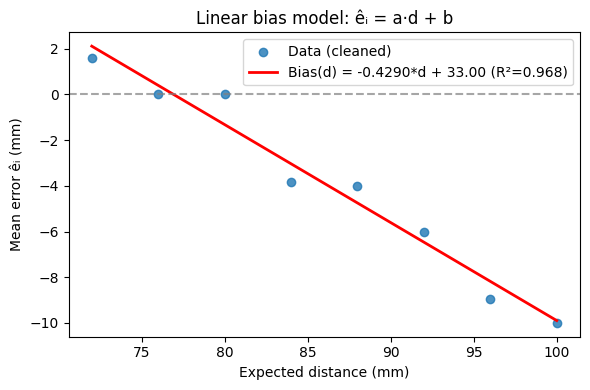

Linear bias: a = -0.4290, b = 33.00 mm, R² = 0.968


In [36]:
# Parametric linear bias model: bias(d) = a * d + b
# Fit mean_error = a * expected_distance + b (êᵢ ≈ bias at that distance)
def fit_linear_bias(stats, x_col="expected_distance", e_col="mean_error"):
    """Fit ê = a*x + b; returns dict with a, b, R² and fitted values."""
    s = stats.dropna(subset=[x_col, e_col])
    if len(s) < 2:
        return None
    x = s[x_col].values
    e = s[e_col].values
    slope, intercept, r, p, se = linregress(x, e)
    fitted = slope * x + intercept
    return {
        "a": slope, "b": intercept, "r_squared": r**2,
        "fitted": fitted, "x": x, "e": e, "residuals": e - fitted
    }

def plot_linear_bias(stats, ax=None, label=""):
    fit = fit_linear_bias(stats)
    if fit is None:
        return None
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    x, e = fit["x"], fit["e"]
    ax.scatter(x, e, alpha=0.8, label="Data" + (f" ({label})" if label else ""))
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, fit["a"] * x_line + fit["b"], "r-", lw=2,
            label=f"Bias(d) = {fit['a']:.4f}*d + {fit['b']:.2f} (R²={fit['r_squared']:.3f})")
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error êᵢ (mm)")
    ax.legend()
    return fit

# Fit and plot linear bias (cleaned data)
fit_bias_cleaned = plot_linear_bias(stats_err_cleaned, label="cleaned")
plt.title("Linear bias model: êᵢ = a·d + b")
plt.tight_layout()
plt.show()
if fit_bias_cleaned:
    print(f"Linear bias: a = {fit_bias_cleaned['a']:.4f}, b = {fit_bias_cleaned['b']:.2f} mm, R² = {fit_bias_cleaned['r_squared']:.3f}")

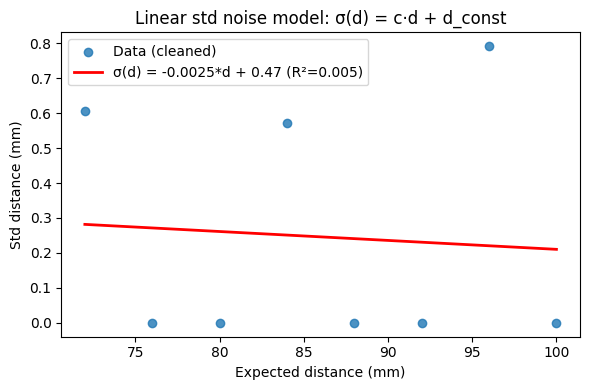

Linear std: c = -0.0025, d_const = 0.47 mm, R² = 0.005


In [37]:
# Parametric linear std noise model: std(d) = c * d + d_const
# Fit std_distance = c * expected_distance + d_const (per-trial spread vs distance)
def fit_linear_std(stats, x_col="expected_distance", std_col="std_distance"):
    """Fit std = c*x + d_const; returns dict with c, d_const, R² and fitted values."""
    s = stats.dropna(subset=[x_col, std_col])
    if len(s) < 2:
        return None
    x = s[x_col].values
    std = s[std_col].values
    slope, intercept, r, p, se = linregress(x, std)
    fitted = slope * x + intercept
    fitted = np.maximum(fitted, 1e-6)  # avoid non-positive for display
    return {
        "c": slope, "d_const": intercept, "r_squared": r**2,
        "fitted": fitted, "x": x, "std": std, "residuals": std - (slope * x + intercept)
    }

def plot_linear_std(stats, ax=None, label=""):
    fit = fit_linear_std(stats)
    if fit is None:
        return None
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    x, std = fit["x"], fit["std"]
    ax.scatter(x, std, alpha=0.8, label="Data" + (f" ({label})" if label else ""))
    x_line = np.linspace(x.min(), x.max(), 100)
    ax.plot(x_line, fit["c"] * x_line + fit["d_const"], "r-", lw=2,
            label=f"σ(d) = {fit['c']:.4f}*d + {fit['d_const']:.2f} (R²={fit['r_squared']:.3f})")
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Std distance (mm)")
    ax.legend()
    return fit

# Fit and plot linear std (cleaned data)
fit_std_cleaned = plot_linear_std(stats_err_cleaned, label="cleaned")
plt.title("Linear std noise model: σ(d) = c·d + d_const")
plt.tight_layout()
plt.show()
if fit_std_cleaned:
    print(f"Linear std: c = {fit_std_cleaned['c']:.4f}, d_const = {fit_std_cleaned['d_const']:.2f} mm, R² = {fit_std_cleaned['r_squared']:.3f}")

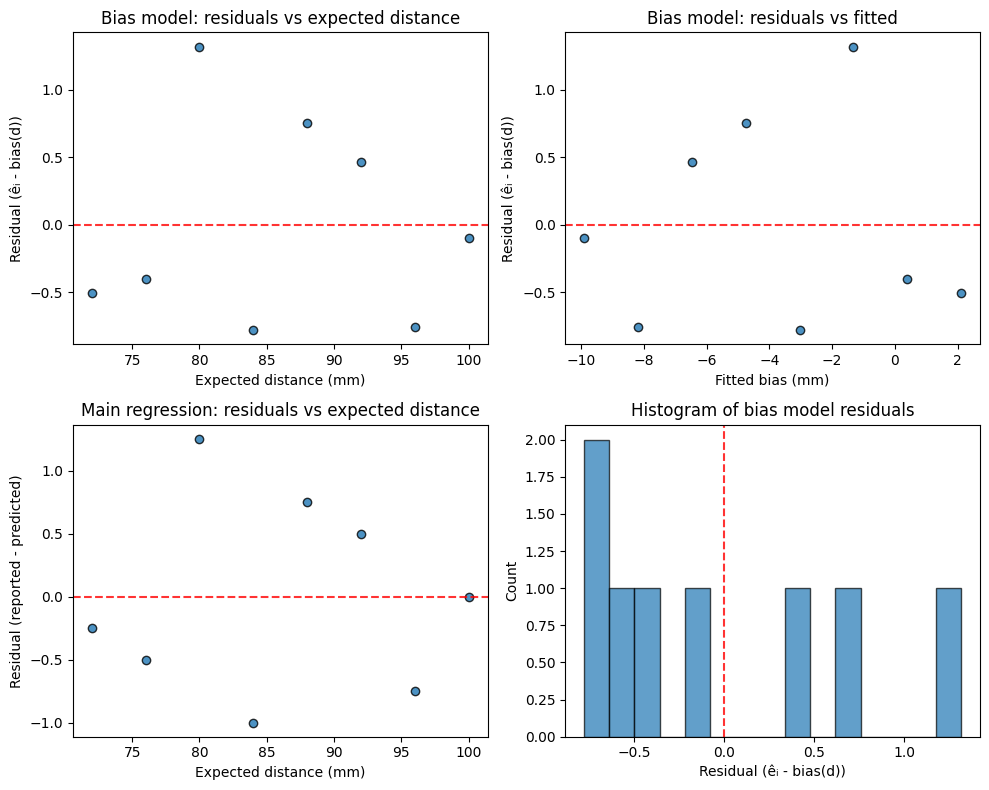

In [38]:
# Residual visualization
# 1) Residuals from linear bias model (êᵢ - (a*d + b))
# 2) Residuals from main regression (median_distance - (slope*expected + intercept))
# 3) Optional: histogram of residuals
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Bias model residuals vs expected distance
if fit_bias_cleaned:
    ax = axes[0, 0]
    ax.scatter(fit_bias_cleaned["x"], fit_bias_cleaned["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (êᵢ - bias(d))")
    ax.set_title("Bias model: residuals vs expected distance")

# Bias model residuals vs fitted
if fit_bias_cleaned:
    ax = axes[0, 1]
    fitted_bias = fit_bias_cleaned["a"] * fit_bias_cleaned["x"] + fit_bias_cleaned["b"]
    ax.scatter(fitted_bias, fit_bias_cleaned["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Fitted bias (mm)")
    ax.set_ylabel("Residual (êᵢ - bias(d))")
    ax.set_title("Bias model: residuals vs fitted")

# Main regression residuals (reported vs expected): residual = median_distance - (slope*d + intercept)
r_main = regression_stats(stats_cleaned, y_col="median_distance")
if r_main is not None:
    pred = r_main["slope"] * stats_cleaned["expected_distance"] + r_main["intercept"]
    res_main = stats_cleaned["median_distance"] - pred
    ax = axes[1, 0]
    ax.scatter(stats_cleaned["expected_distance"], res_main, alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (reported - predicted)")
    ax.set_title("Main regression: residuals vs expected distance")

# Histogram of bias model residuals
if fit_bias_cleaned:
    ax = axes[1, 1]
    ax.hist(fit_bias_cleaned["residuals"], bins=15, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Residual (êᵢ - bias(d))")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of bias model residuals")

plt.tight_layout()
plt.show()

## New dataset: distance_back_pvc_7-20-10.csv

Run both pipelines (normal + error) on this file. **Register caution:** the target may have changed registers between runs; check per-register consistency below before interpreting results.

In [39]:
# Load new CSV and check register consistency (target may have changed registers)
DATA_DIR = "../data"
df_new = pd.read_csv(f"{DATA_DIR}/distance_back_pvc_7-20-10.csv")

# Per-register summary: expected vs mean reported distance (if they diverge, target likely changed register)
print("Per-register check (mean rdistance vs expected distance by trial):")
for reg in sorted(df_new["register"].dropna().unique()):
    reg_int = int(reg)
    sub = df_new[df_new["register"] == reg_int]
    stats_reg = get_stats(df_new, register=reg_int)
    if len(stats_reg) == 0:
        continue
    mean_err = (stats_reg["mean_distance"] - stats_reg["expected_distance"]).abs().mean()
    print(f"  Register {reg_int}: trials={stats_reg['trial'].nunique()}, "
          f"expected range [{stats_reg['expected_distance'].min():.0f}, {stats_reg['expected_distance'].max():.0f}] mm, "
          f"mean |error| = {mean_err:.1f} mm")
print("\n→ Use the register with smallest mean |error| (best tracks expected distance).")
REG_NEW = 1  # Set to 0 or 1 (or main register) after checking above; 1 often matches target if it changed.
df_new_reg = df_new[df_new["register"] == REG_NEW].copy()
df_new_reg["error_mm"] = df_new_reg["rdistance"] - df_new_reg["edistance"]

Per-register check (mean rdistance vs expected distance by trial):
  Register 0: trials=14, expected range [70, 200] mm, mean |error| = 97.4 mm
  Register 1: trials=14, expected range [70, 200] mm, mean |error| = 47.2 mm
  Register 2: trials=13, expected range [70, 200] mm, mean |error| = 60.4 mm
  Register 3: trials=3, expected range [120, 140] mm, mean |error| = 45.1 mm

→ Use the register with smallest mean |error| (best tracks expected distance).


C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


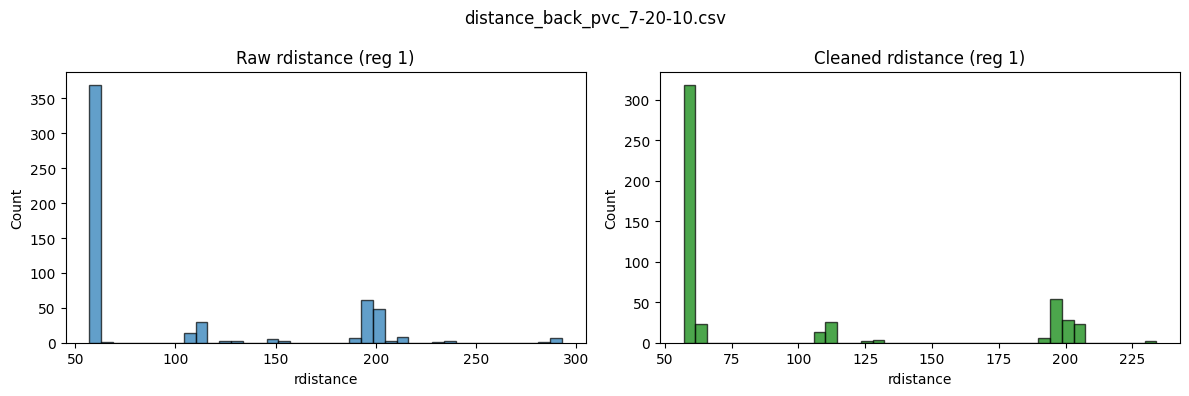

In [40]:
# --- Normal pipeline (new dataset, register REG_NEW) ---
# Histograms: raw and cleaned rdistance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_new_reg, value_col="rdistance", bins=40, ax=axes[0], title=f"Raw rdistance (reg {REG_NEW})")
plot_histogram_cleaned(df_new_reg, value_col="rdistance", n_std=2.0, bins=40, ax=axes[1], title=f"Cleaned rdistance (reg {REG_NEW})")
plt.suptitle("distance_back_pvc_7-20-10.csv")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


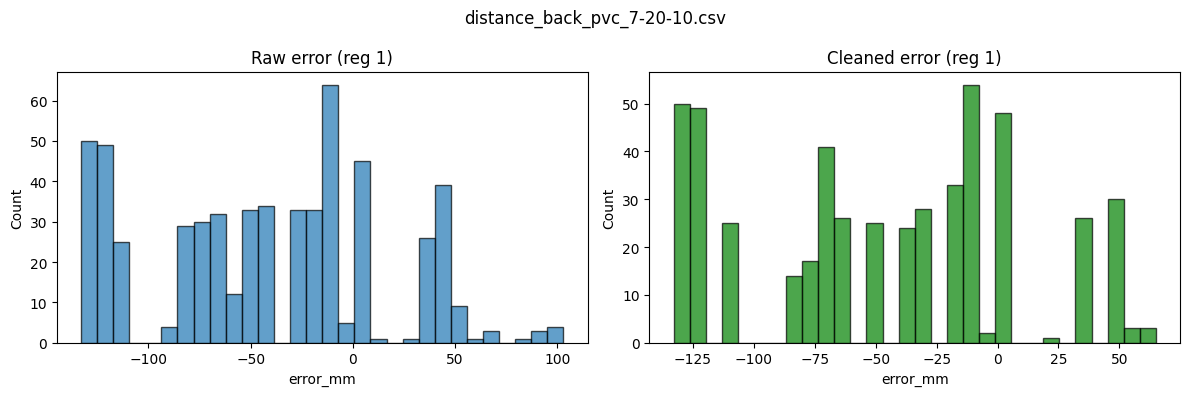

In [41]:
# Histograms: raw and cleaned error (new dataset)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_new_reg, value_col="error_mm", bins=30, ax=axes[0], title=f"Raw error (reg {REG_NEW})")
plot_histogram_cleaned(df_new_reg, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1], title=f"Cleaned error (reg {REG_NEW})")
plt.suptitle("distance_back_pvc_7-20-10.csv")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


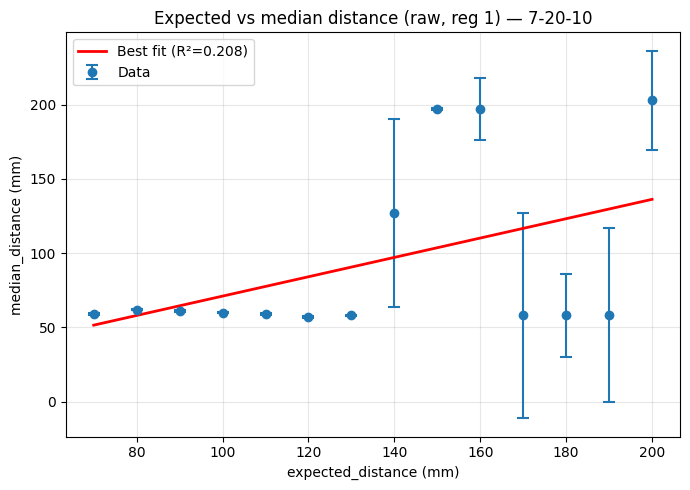

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


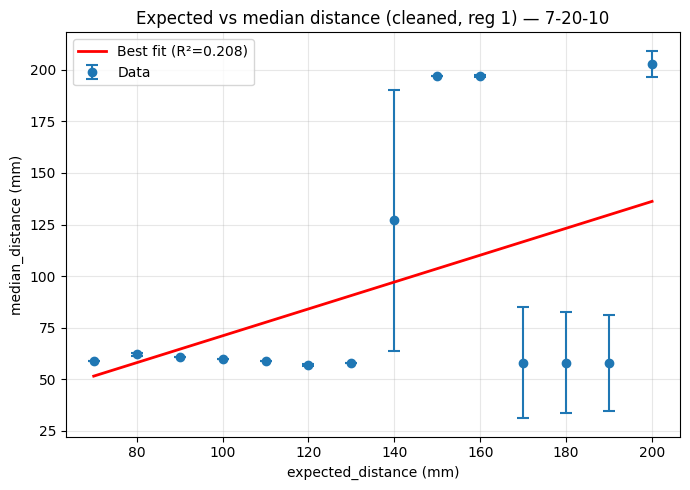

In [42]:
# Expected vs actual (raw and cleaned) — new dataset
stats_new_raw = get_stats(df_new, register=REG_NEW)
stats_new_cleaned = get_stats(remove_outliers_per_trial(df_new_reg, n_std=2.0), register=None)
plot_expected_vs_actual(stats_new_raw, y_col="median_distance", y_err_col="std_distance",
                        title=f"Expected vs median distance (raw, reg {REG_NEW}) — 7-20-10")
plt.show()
plot_expected_vs_actual_from_cleaned(df_new, register=REG_NEW, n_std=2.0,
                                    title=f"Expected vs median distance (cleaned, reg {REG_NEW}) — 7-20-10")
plt.show()

In [43]:
# Regression stats for new dataset
for name, s in [("raw", stats_new_raw), ("cleaned", stats_new_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"7-20-10 ({name}, reg {REG_NEW}): slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

7-20-10 (raw, reg 1): slope=0.652, intercept=5.855, R²=0.208
7-20-10 (cleaned, reg 1): slope=0.652, intercept=5.855, R²=0.208


C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


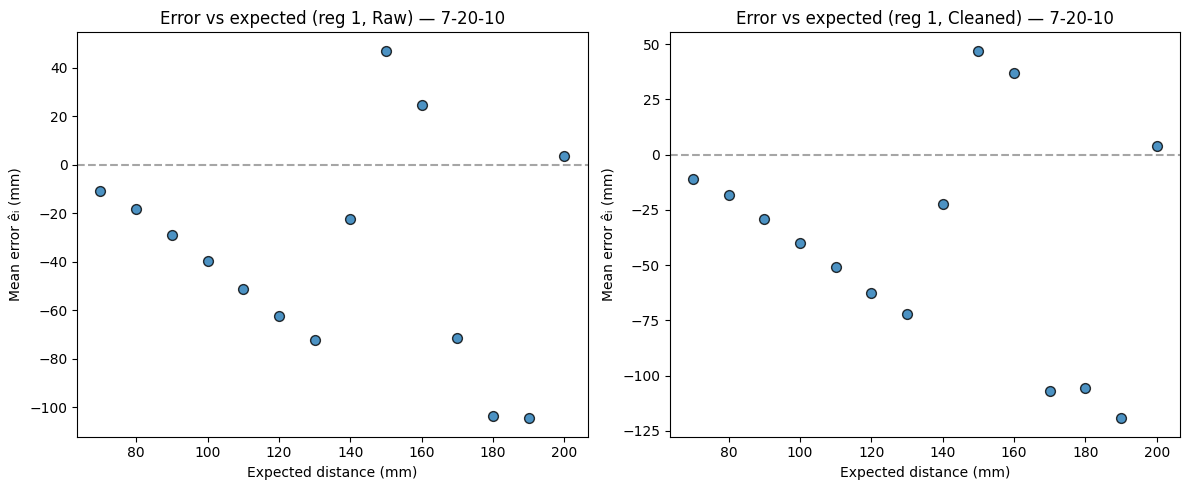

In [44]:
# --- Error pipeline (new dataset) ---
# Scatter: error êᵢ vs expected distance
stats_new_err = get_stats(df_new, register=REG_NEW)
stats_new_err_cleaned = get_stats(remove_outliers_per_trial(df_new_reg, n_std=2.0), register=None)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, s, label in [(axes[0], stats_new_err, "Raw"), (axes[1], stats_new_err_cleaned, "Cleaned")]:
    ax.scatter(s["expected_distance"], s["mean_error"], alpha=0.8, edgecolors="k", s=50)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error êᵢ (mm)")
    ax.set_title(f"Error vs expected (reg {REG_NEW}, {label}) — 7-20-10")
plt.tight_layout()
plt.show()

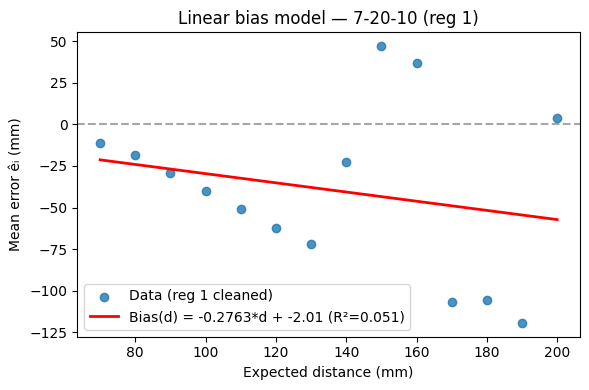

Bias: a = -0.2763, b = -2.01 mm, R² = 0.051


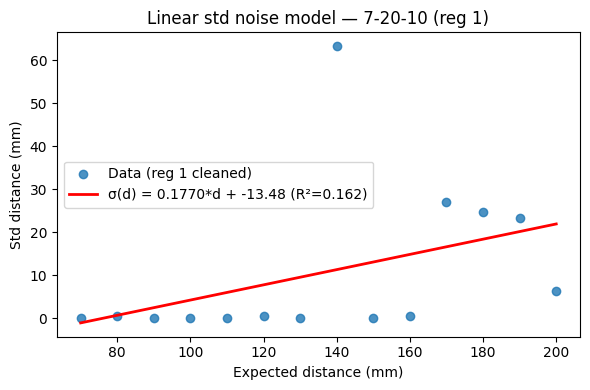

Std: c = 0.1770, d_const = -13.48 mm, R² = 0.162


In [45]:
# Linear bias and linear std models — new dataset
fit_bias_new = plot_linear_bias(stats_new_err_cleaned, label=f"reg {REG_NEW} cleaned")
plt.title(f"Linear bias model — 7-20-10 (reg {REG_NEW})")
plt.tight_layout()
plt.show()
if fit_bias_new:
    print(f"Bias: a = {fit_bias_new['a']:.4f}, b = {fit_bias_new['b']:.2f} mm, R² = {fit_bias_new['r_squared']:.3f}")

fit_std_new = plot_linear_std(stats_new_err_cleaned, label=f"reg {REG_NEW} cleaned")
plt.title(f"Linear std noise model — 7-20-10 (reg {REG_NEW})")
plt.tight_layout()
plt.show()
if fit_std_new:
    print(f"Std: c = {fit_std_new['c']:.4f}, d_const = {fit_std_new['d_const']:.2f} mm, R² = {fit_std_new['r_squared']:.3f}")

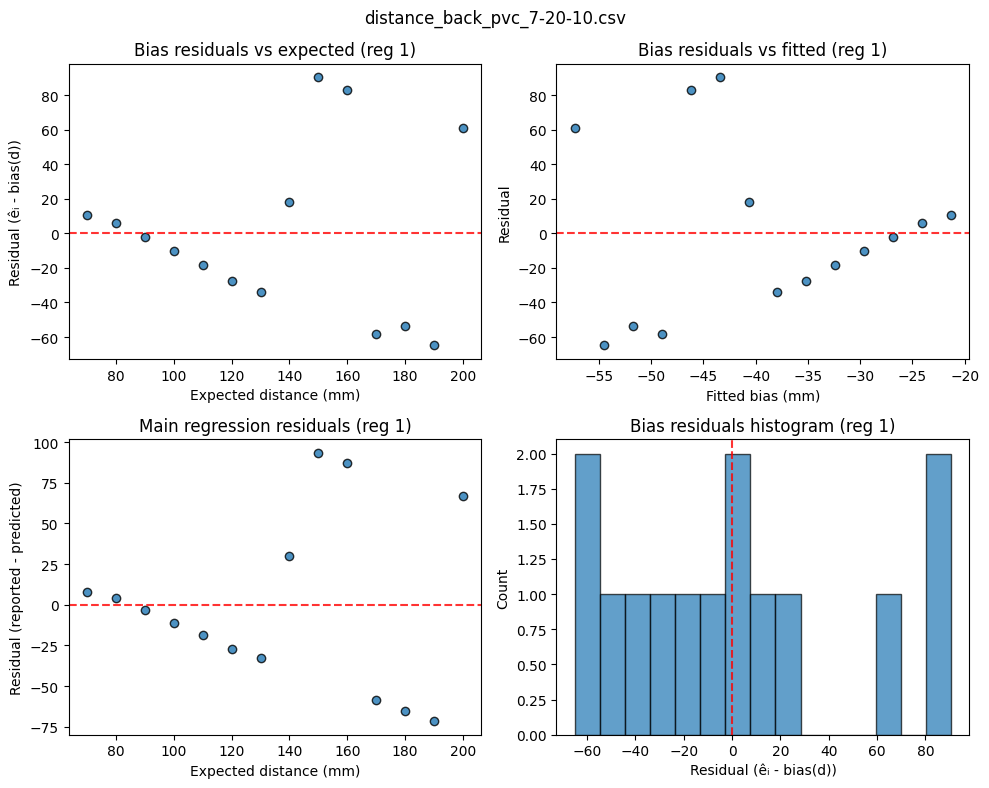

In [46]:
# Residual visualization — new dataset (reg REG_NEW)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Bias residuals vs expected
if fit_bias_new:
    ax = axes[0, 0]
    ax.scatter(fit_bias_new["x"], fit_bias_new["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (êᵢ - bias(d))")
    ax.set_title(f"Bias residuals vs expected (reg {REG_NEW})")
# Bias residuals vs fitted
if fit_bias_new:
    ax = axes[0, 1]
    fitted_b = fit_bias_new["a"] * fit_bias_new["x"] + fit_bias_new["b"]
    ax.scatter(fitted_b, fit_bias_new["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Fitted bias (mm)")
    ax.set_ylabel("Residual")
    ax.set_title(f"Bias residuals vs fitted (reg {REG_NEW})")
# Main regression residuals (reported - predicted)
r_main_new = regression_stats(stats_new_cleaned, y_col="median_distance")
if r_main_new is not None:
    pred_new = r_main_new["slope"] * stats_new_cleaned["expected_distance"] + r_main_new["intercept"]
    res_main_new = stats_new_cleaned["median_distance"] - pred_new
    ax = axes[1, 0]
    ax.scatter(stats_new_cleaned["expected_distance"], res_main_new, alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (reported - predicted)")
    ax.set_title(f"Main regression residuals (reg {REG_NEW})")
# Histogram of bias residuals
if fit_bias_new:
    ax = axes[1, 1]
    ax.hist(fit_bias_new["residuals"], bins=15, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Residual (êᵢ - bias(d))")
    ax.set_ylabel("Count")
    ax.set_title(f"Bias residuals histogram (reg {REG_NEW})")
plt.suptitle("distance_back_pvc_7-20-10.csv")
plt.tight_layout()
plt.show()

## Dataset: distance_back_pvc_7-20-10_v2.csv

Same pipelines as 7-20-10, but **v2 has multiple registers** (target switches between reg 0 and reg 1 across trials). We first show distance vs expected for all registers, then run the normal and error pipelines **separately for reg 0 and reg 1** so each target segment is analyzed clearly.

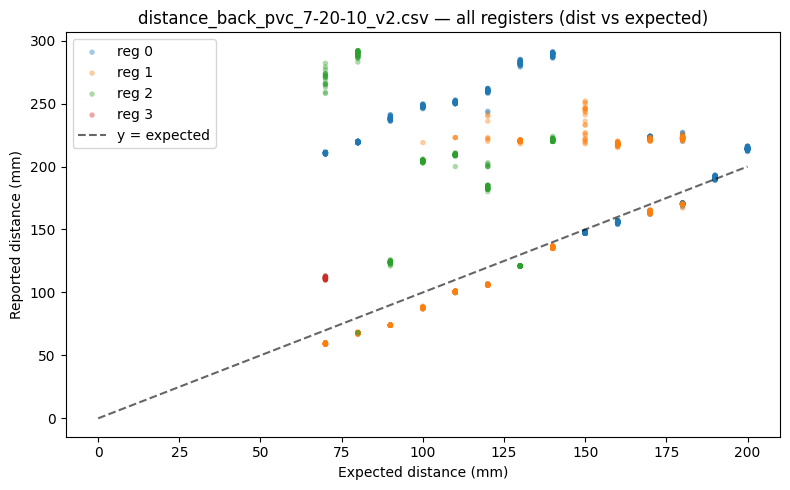

In [47]:
# Load v2 and show dist vs expected for ALL registers (target switch visible by color)
DATA_DIR = "../data"
df_v2 = pd.read_csv(f"{DATA_DIR}/distance_back_pvc_7-20-10_v2.csv")

fig, ax = plt.subplots(figsize=(8, 5))
for reg in sorted(df_v2["register"].dropna().unique()):
    r = int(reg)
    sub = df_v2[df_v2["register"] == reg]
    ax.scatter(sub["edistance"], sub["rdistance"], alpha=0.4, s=15, label=f"reg {r}", edgecolors="none")
ax.plot([0, df_v2["edistance"].max()], [0, df_v2["edistance"].max()], "k--", alpha=0.6, label="y = expected")
ax.set_xlabel("Expected distance (mm)")
ax.set_ylabel("Reported distance (mm)")
ax.set_title("distance_back_pvc_7-20-10_v2.csv — all registers (dist vs expected)")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

In [48]:
# Segment by target register: run pipelines for reg 0 and reg 1 separately
print("Per-register summary (v2):")
for reg in sorted(df_v2["register"].dropna().unique()):
    reg_int = int(reg)
    stats_reg = get_stats(df_v2, register=reg_int)
    if len(stats_reg) == 0:
        continue
    mean_err = (stats_reg["mean_distance"] - stats_reg["expected_distance"]).abs().mean()
    print(f"  Register {reg_int}: trials={stats_reg['trial'].nunique()}, "
          f"expected range [{stats_reg['expected_distance'].min():.0f}, {stats_reg['expected_distance'].max():.0f}] mm, "
          f"mean |error| = {mean_err:.1f} mm")

df_v2_reg0 = df_v2[df_v2["register"] == 0].copy()
df_v2_reg0["error_mm"] = df_v2_reg0["rdistance"] - df_v2_reg0["edistance"]
df_v2_reg1 = df_v2[df_v2["register"] == 1].copy()
df_v2_reg1["error_mm"] = df_v2_reg1["rdistance"] - df_v2_reg1["edistance"]
print("\nPipelines below run separately for reg 0 and reg 1.")

Per-register summary (v2):
  Register 0: trials=14, expected range [70, 200] mm, mean |error| = 83.2 mm
  Register 1: trials=12, expected range [70, 180] mm, mean |error| = 27.6 mm
  Register 2: trials=8, expected range [70, 140] mm, mean |error| = 92.8 mm
  Register 3: trials=1, expected range [70, 70] mm, mean |error| = 41.5 mm

Pipelines below run separately for reg 0 and reg 1.


C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


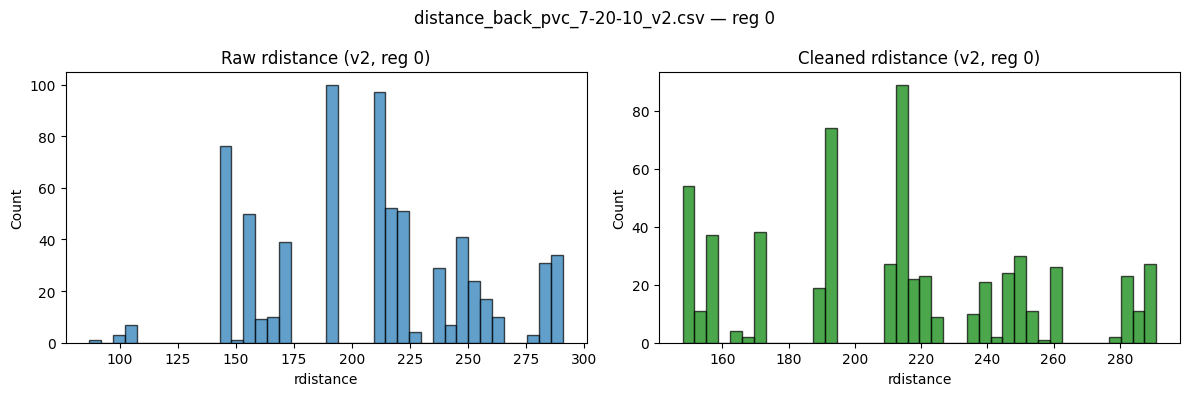

In [49]:
# --- v2 REG 0: Normal pipeline ---
# Histograms: raw and cleaned rdistance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_v2_reg0, value_col="rdistance", bins=40, ax=axes[0], title="Raw rdistance (v2, reg 0)")
plot_histogram_cleaned(df_v2_reg0, value_col="rdistance", n_std=2.0, bins=40, ax=axes[1], title="Cleaned rdistance (v2, reg 0)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 0")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


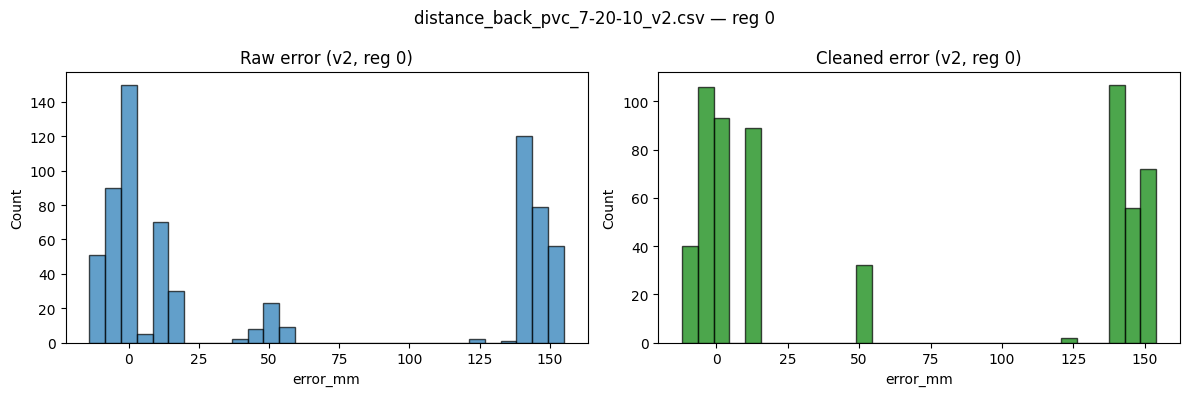

In [50]:
# Histograms: raw and cleaned error (v2, reg 0)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_v2_reg0, value_col="error_mm", bins=30, ax=axes[0], title="Raw error (v2, reg 0)")
plot_histogram_cleaned(df_v2_reg0, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1], title="Cleaned error (v2, reg 0)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 0")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


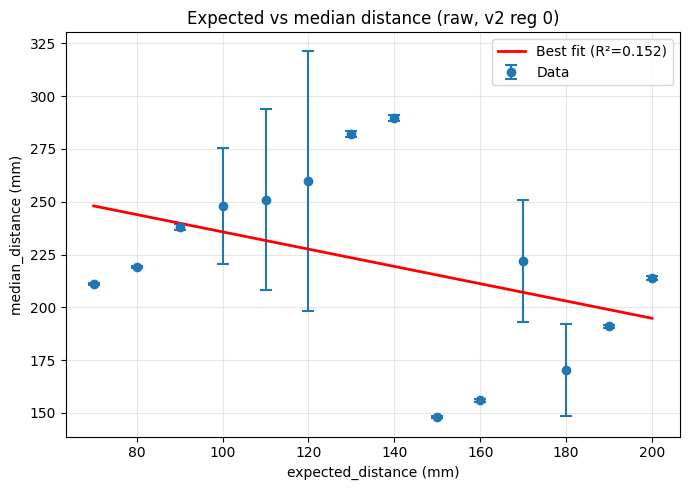

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


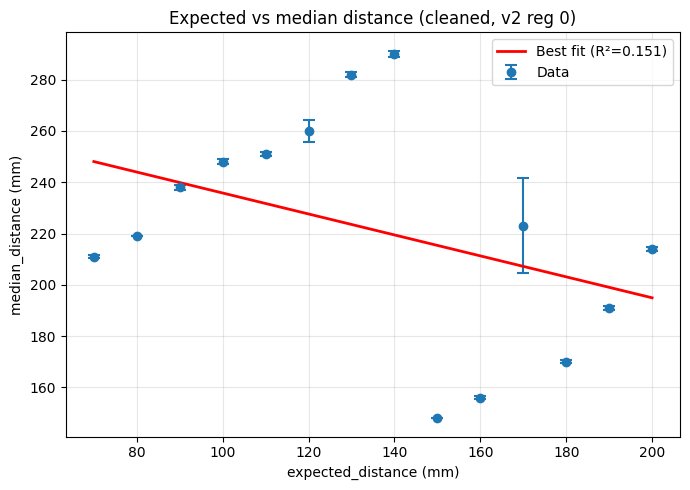

v2 reg 0 (raw): slope=-0.409, intercept=276.675, R²=0.152
v2 reg 0 (cleaned): slope=-0.409, intercept=276.657, R²=0.151


In [51]:
# Expected vs actual (v2, reg 0)
stats_v2_r0_raw = get_stats(df_v2, register=0)
stats_v2_r0_cleaned = get_stats(remove_outliers_per_trial(df_v2_reg0, n_std=2.0), register=None)
plot_expected_vs_actual(stats_v2_r0_raw, y_col="median_distance", y_err_col="std_distance",
                        title="Expected vs median distance (raw, v2 reg 0)")
plt.show()
plot_expected_vs_actual_from_cleaned(df_v2, register=0, n_std=2.0,
                                     title="Expected vs median distance (cleaned, v2 reg 0)")
plt.show()
for name, s in [("raw", stats_v2_r0_raw), ("cleaned", stats_v2_r0_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"v2 reg 0 ({name}): slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


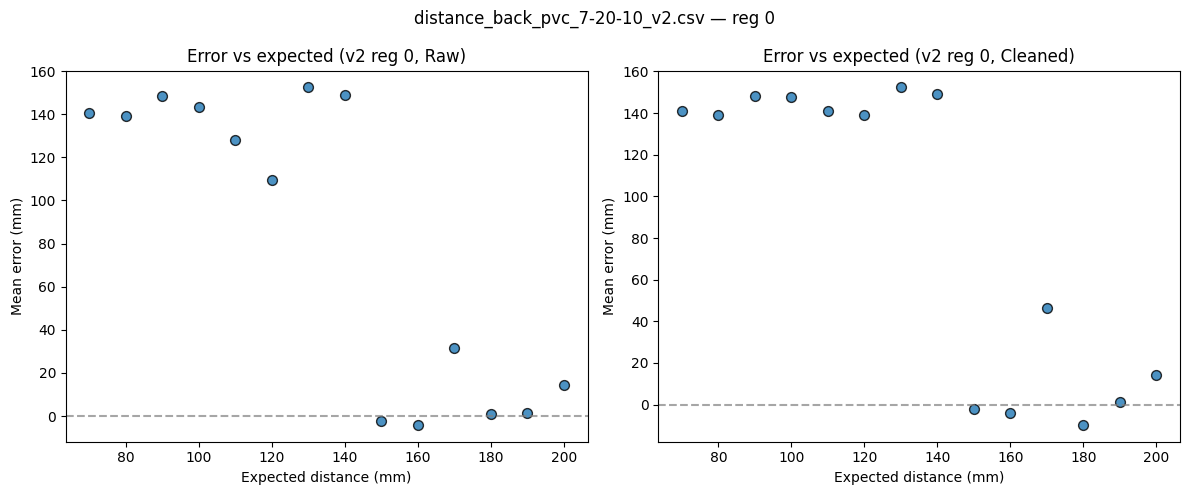

In [52]:
# --- v2 REG 0: Error pipeline ---
stats_v2_r0_err = get_stats(df_v2, register=0)
stats_v2_r0_err_cleaned = get_stats(remove_outliers_per_trial(df_v2_reg0, n_std=2.0), register=None)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, s, label in [(axes[0], stats_v2_r0_err, "Raw"), (axes[1], stats_v2_r0_err_cleaned, "Cleaned")]:
    ax.scatter(s["expected_distance"], s["mean_error"], alpha=0.8, edgecolors="k", s=50)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error (mm)")
    ax.set_title(f"Error vs expected (v2 reg 0, {label})")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 0")
plt.tight_layout()
plt.show()

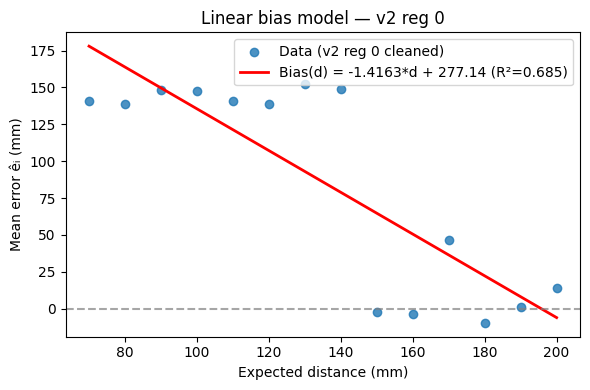

Bias (v2 reg 0): a = -1.4163, b = 277.14 mm, R² = 0.685


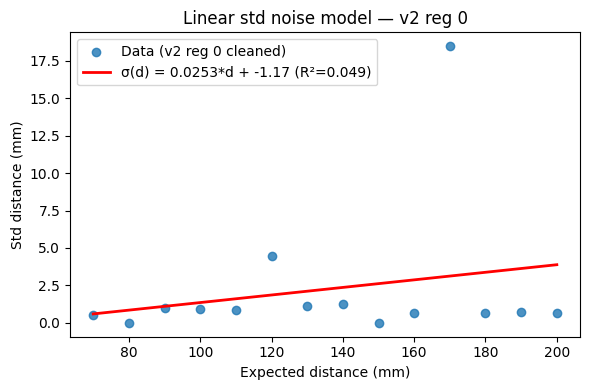

Std (v2 reg 0): c = 0.0253, d_const = -1.17 mm, R² = 0.049


In [53]:
# Linear bias and std (v2 reg 0)
fit_bias_v2_r0 = plot_linear_bias(stats_v2_r0_err_cleaned, label="v2 reg 0 cleaned")
plt.title("Linear bias model — v2 reg 0")
plt.tight_layout()
plt.show()
if fit_bias_v2_r0:
    print(f"Bias (v2 reg 0): a = {fit_bias_v2_r0['a']:.4f}, b = {fit_bias_v2_r0['b']:.2f} mm, R² = {fit_bias_v2_r0['r_squared']:.3f}")

fit_std_v2_r0 = plot_linear_std(stats_v2_r0_err_cleaned, label="v2 reg 0 cleaned")
plt.title("Linear std noise model — v2 reg 0")
plt.tight_layout()
plt.show()
if fit_std_v2_r0:
    print(f"Std (v2 reg 0): c = {fit_std_v2_r0['c']:.4f}, d_const = {fit_std_v2_r0['d_const']:.2f} mm, R² = {fit_std_v2_r0['r_squared']:.3f}")

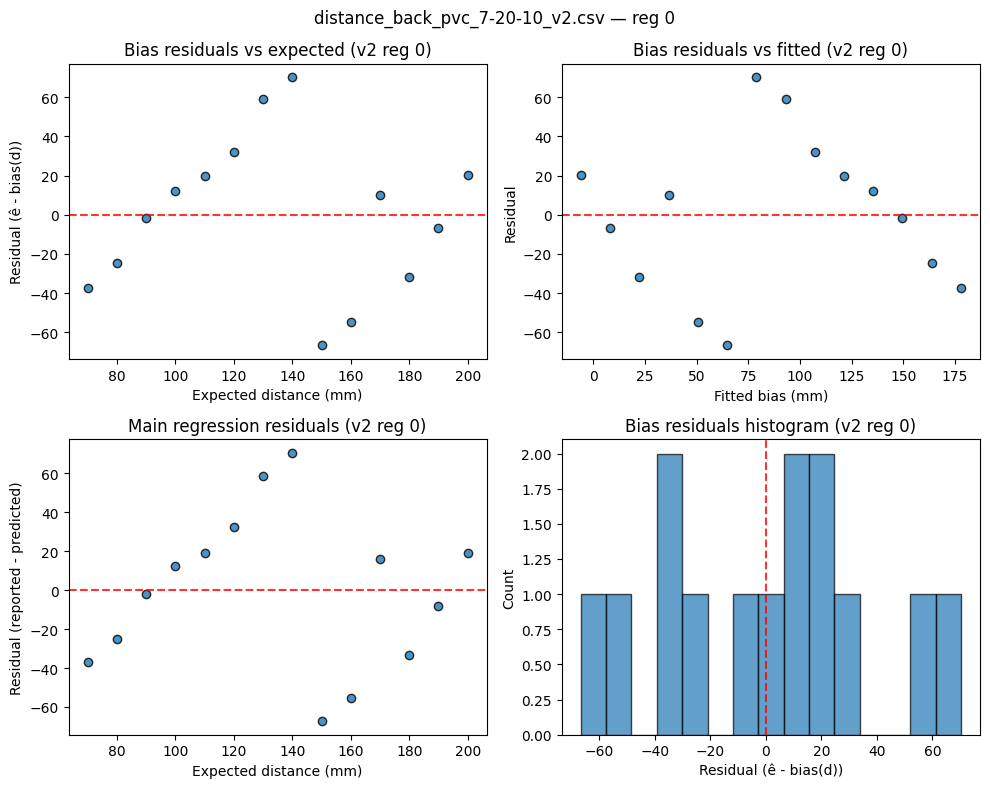

In [54]:
# Residual visualization (v2 reg 0)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
if fit_bias_v2_r0:
    ax = axes[0, 0]
    ax.scatter(fit_bias_v2_r0["x"], fit_bias_v2_r0["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (ê - bias(d))")
    ax.set_title("Bias residuals vs expected (v2 reg 0)")
if fit_bias_v2_r0:
    ax = axes[0, 1]
    fitted_b = fit_bias_v2_r0["a"] * fit_bias_v2_r0["x"] + fit_bias_v2_r0["b"]
    ax.scatter(fitted_b, fit_bias_v2_r0["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Fitted bias (mm)")
    ax.set_ylabel("Residual")
    ax.set_title("Bias residuals vs fitted (v2 reg 0)")
r_main_v2_r0 = regression_stats(stats_v2_r0_cleaned, y_col="median_distance")
if r_main_v2_r0 is not None:
    pred = r_main_v2_r0["slope"] * stats_v2_r0_cleaned["expected_distance"] + r_main_v2_r0["intercept"]
    res_main = stats_v2_r0_cleaned["median_distance"] - pred
    ax = axes[1, 0]
    ax.scatter(stats_v2_r0_cleaned["expected_distance"], res_main, alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (reported - predicted)")
    ax.set_title("Main regression residuals (v2 reg 0)")
if fit_bias_v2_r0:
    ax = axes[1, 1]
    ax.hist(fit_bias_v2_r0["residuals"], bins=15, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Residual (ê - bias(d))")
    ax.set_ylabel("Count")
    ax.set_title("Bias residuals histogram (v2 reg 0)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 0")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


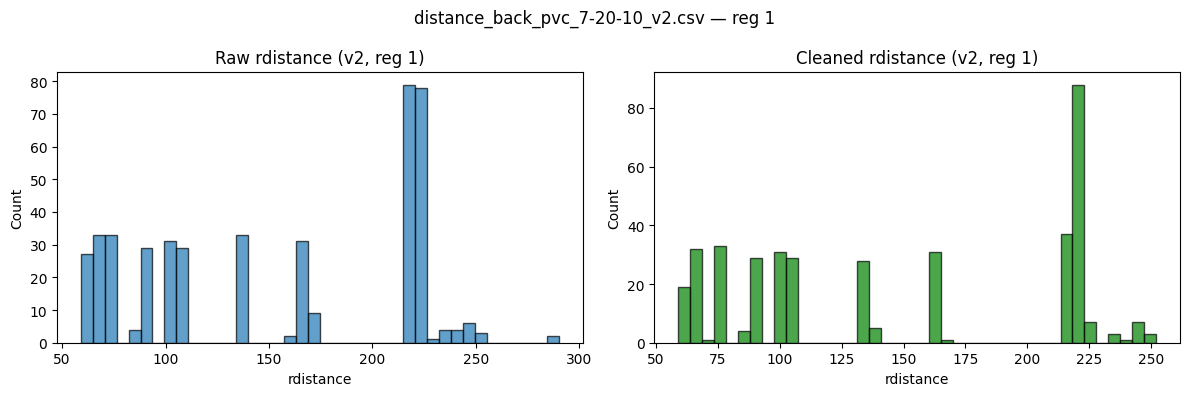

In [55]:
# --- v2 REG 1: Normal pipeline ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_v2_reg1, value_col="rdistance", bins=40, ax=axes[0], title="Raw rdistance (v2, reg 1)")
plot_histogram_cleaned(df_v2_reg1, value_col="rdistance", n_std=2.0, bins=40, ax=axes[1], title="Cleaned rdistance (v2, reg 1)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 1")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


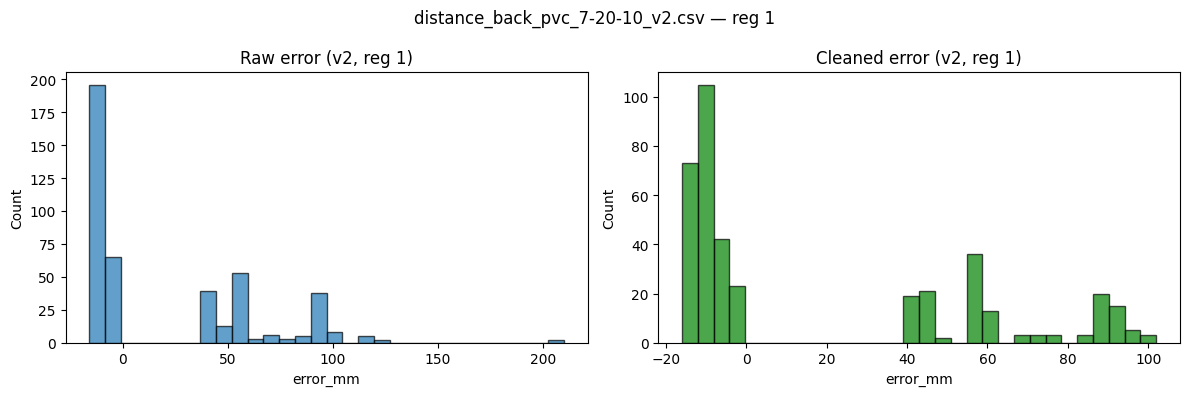

In [56]:
# Histograms: raw and cleaned error (v2, reg 1)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_v2_reg1, value_col="error_mm", bins=30, ax=axes[0], title="Raw error (v2, reg 1)")
plot_histogram_cleaned(df_v2_reg1, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1], title="Cleaned error (v2, reg 1)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 1")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


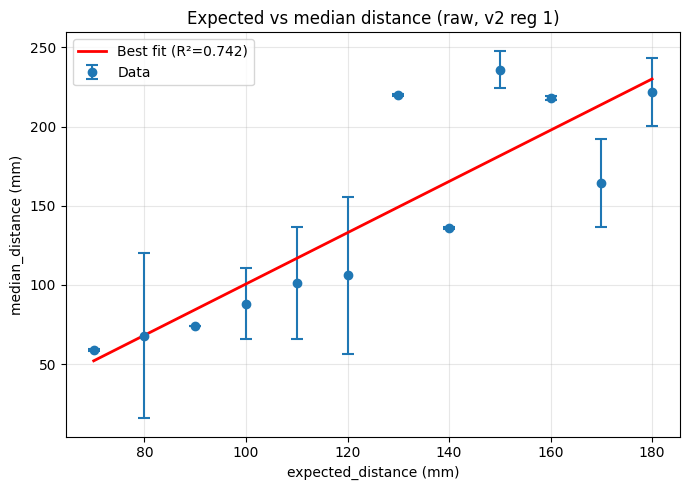

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


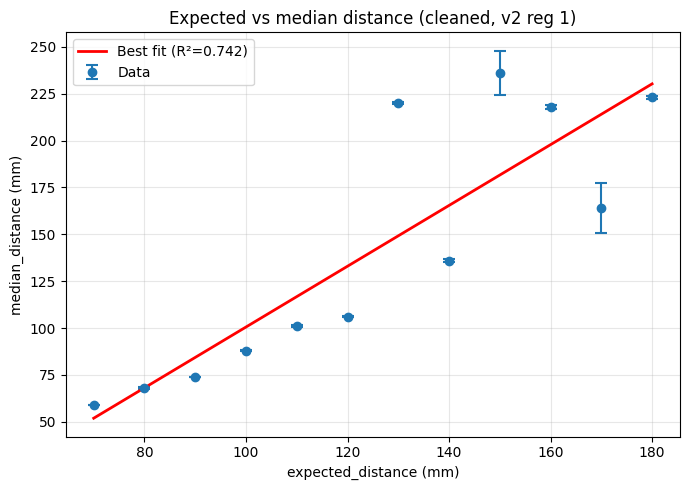

v2 reg 1 (raw): slope=1.618, intercept=-61.253, R²=0.742
v2 reg 1 (cleaned): slope=1.621, intercept=-61.495, R²=0.742


In [57]:
# Expected vs actual (v2, reg 1)
stats_v2_r1_raw = get_stats(df_v2, register=1)
stats_v2_r1_cleaned = get_stats(remove_outliers_per_trial(df_v2_reg1, n_std=2.0), register=None)
plot_expected_vs_actual(stats_v2_r1_raw, y_col="median_distance", y_err_col="std_distance",
                        title="Expected vs median distance (raw, v2 reg 1)")
plt.show()
plot_expected_vs_actual_from_cleaned(df_v2, register=1, n_std=2.0,
                                     title="Expected vs median distance (cleaned, v2 reg 1)")
plt.show()
for name, s in [("raw", stats_v2_r1_raw), ("cleaned", stats_v2_r1_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"v2 reg 1 ({name}): slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


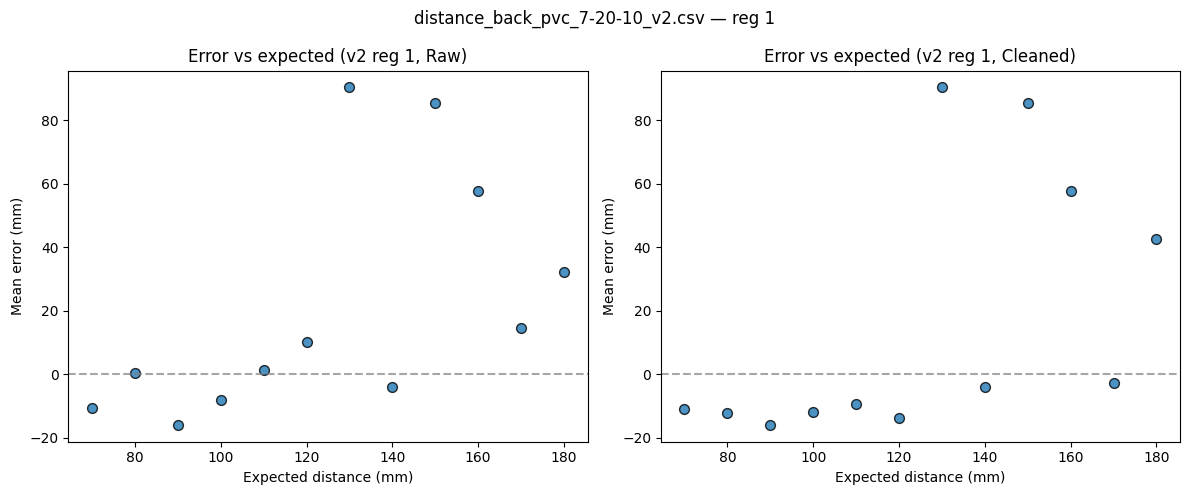

In [58]:
# --- v2 REG 1: Error pipeline ---
stats_v2_r1_err = get_stats(df_v2, register=1)
stats_v2_r1_err_cleaned = get_stats(remove_outliers_per_trial(df_v2_reg1, n_std=2.0), register=None)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, s, label in [(axes[0], stats_v2_r1_err, "Raw"), (axes[1], stats_v2_r1_err_cleaned, "Cleaned")]:
    ax.scatter(s["expected_distance"], s["mean_error"], alpha=0.8, edgecolors="k", s=50)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error (mm)")
    ax.set_title(f"Error vs expected (v2 reg 1, {label})")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 1")
plt.tight_layout()
plt.show()

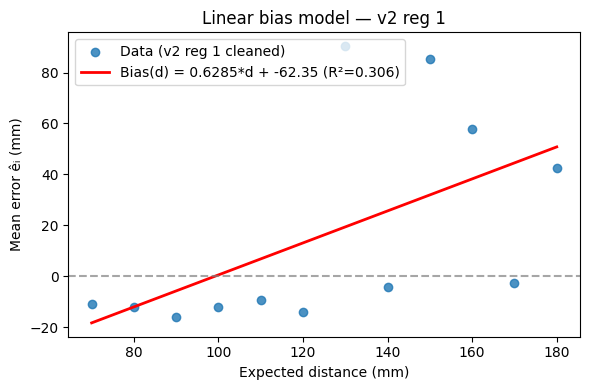

Bias (v2 reg 1): a = 0.6285, b = -62.35 mm, R² = 0.306


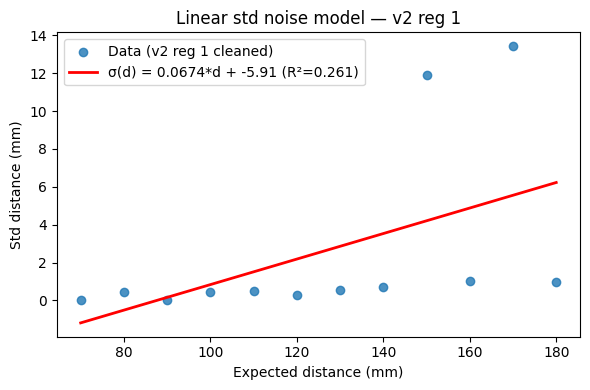

Std (v2 reg 1): c = 0.0674, d_const = -5.91 mm, R² = 0.261


In [59]:
# Linear bias and std (v2 reg 1)
fit_bias_v2_r1 = plot_linear_bias(stats_v2_r1_err_cleaned, label="v2 reg 1 cleaned")
plt.title("Linear bias model — v2 reg 1")
plt.tight_layout()
plt.show()
if fit_bias_v2_r1:
    print(f"Bias (v2 reg 1): a = {fit_bias_v2_r1['a']:.4f}, b = {fit_bias_v2_r1['b']:.2f} mm, R² = {fit_bias_v2_r1['r_squared']:.3f}")

fit_std_v2_r1 = plot_linear_std(stats_v2_r1_err_cleaned, label="v2 reg 1 cleaned")
plt.title("Linear std noise model — v2 reg 1")
plt.tight_layout()
plt.show()
if fit_std_v2_r1:
    print(f"Std (v2 reg 1): c = {fit_std_v2_r1['c']:.4f}, d_const = {fit_std_v2_r1['d_const']:.2f} mm, R² = {fit_std_v2_r1['r_squared']:.3f}")

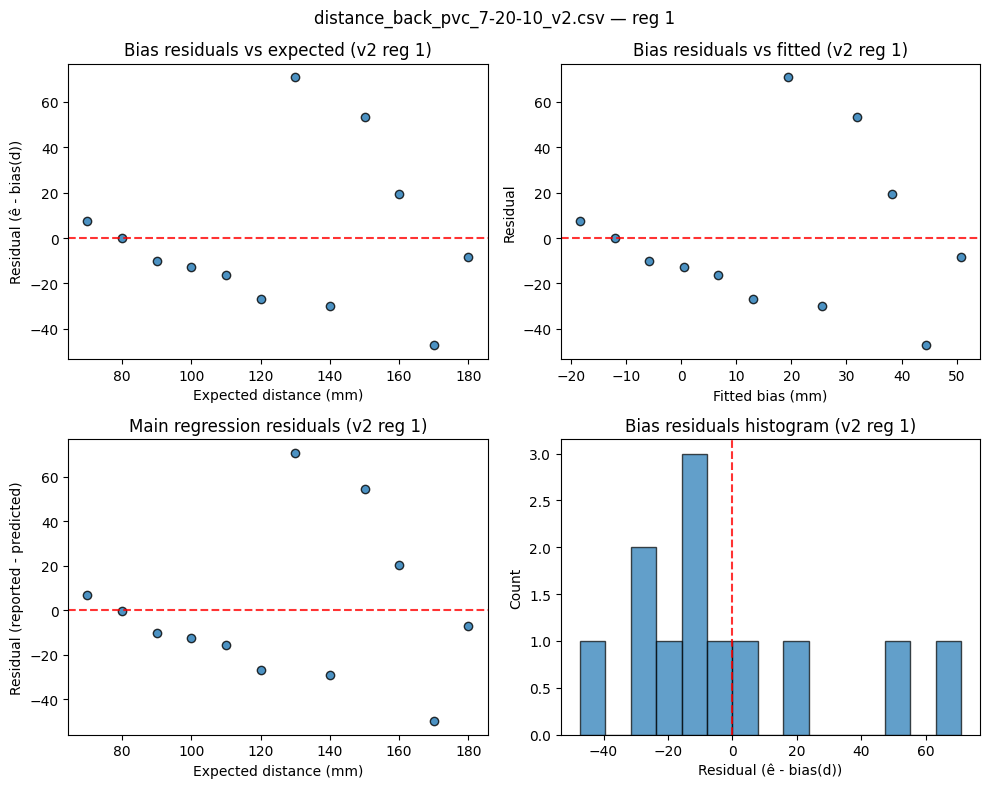

In [60]:
# Residual visualization (v2 reg 1)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
if fit_bias_v2_r1:
    ax = axes[0, 0]
    ax.scatter(fit_bias_v2_r1["x"], fit_bias_v2_r1["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (ê - bias(d))")
    ax.set_title("Bias residuals vs expected (v2 reg 1)")
if fit_bias_v2_r1:
    ax = axes[0, 1]
    fitted_b = fit_bias_v2_r1["a"] * fit_bias_v2_r1["x"] + fit_bias_v2_r1["b"]
    ax.scatter(fitted_b, fit_bias_v2_r1["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Fitted bias (mm)")
    ax.set_ylabel("Residual")
    ax.set_title("Bias residuals vs fitted (v2 reg 1)")
r_main_v2_r1 = regression_stats(stats_v2_r1_cleaned, y_col="median_distance")
if r_main_v2_r1 is not None:
    pred = r_main_v2_r1["slope"] * stats_v2_r1_cleaned["expected_distance"] + r_main_v2_r1["intercept"]
    res_main = stats_v2_r1_cleaned["median_distance"] - pred
    ax = axes[1, 0]
    ax.scatter(stats_v2_r1_cleaned["expected_distance"], res_main, alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (reported - predicted)")
    ax.set_title("Main regression residuals (v2 reg 1)")
if fit_bias_v2_r1:
    ax = axes[1, 1]
    ax.hist(fit_bias_v2_r1["residuals"], bins=15, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Residual (ê - bias(d))")
    ax.set_ylabel("Count")
    ax.set_title("Bias residuals histogram (v2 reg 1)")
plt.suptitle("distance_back_pvc_7-20-10_v2.csv — reg 1")
plt.tight_layout()
plt.show()

## Clean to only involve "good" registers. 

In [71]:
DATA_DIR = "../data"
df_v2_bad = pd.read_csv(f"{DATA_DIR}/distance_back_pvc_7-20-10_v2.csv")
df_v2_reg0_0_good = df_v2_bad[(df_v2_bad["register"] == 0) & (df_v2_bad["trial"].isin([0, 1, 2, 4, 5, 8]))]
df_v2_reg0_1_good = df_v2_bad[(df_v2_bad["register"] == 1) & (df_v2_bad["trial"].isin([3, 6, 9, 10, 11, 12, 13]))]
df_v2_reg0_2_good = df_v2_bad[(df_v2_bad["register"] == 2) & (df_v2_bad["trial"].isin([7]))]

df_v2_sorted_good = pd.concat([df_v2_reg0_0_good, df_v2_reg0_1_good, df_v2_reg0_2_good], ignore_index=True)


## Dataset: df_v2_sorted_good (cleaned — correct registers per trial)

This dataset contains only the distances that correspond to the target, with the correct register identified per trial. Run the same normal and error pipelines on this cleaned dataset.

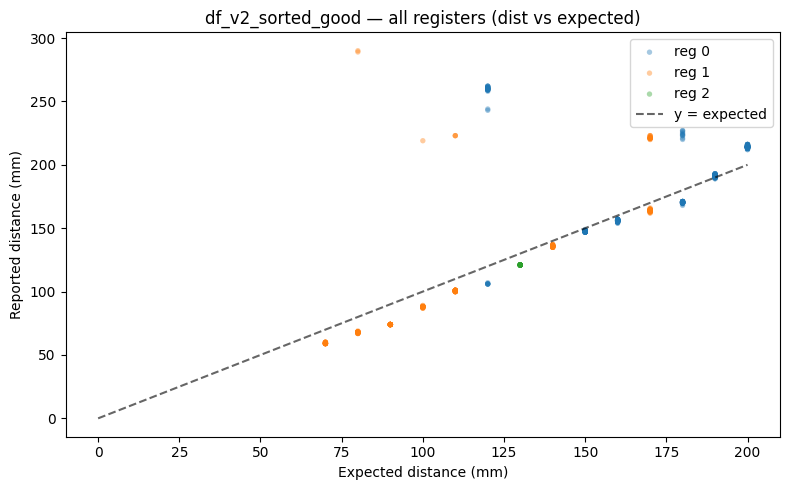

In [72]:
# Initial scatter: dist vs expected for all registers in cleaned dataset
fig, ax = plt.subplots(figsize=(8, 5))
for reg in sorted(df_v2_sorted_good["register"].dropna().unique()):
    r = int(reg)
    sub = df_v2_sorted_good[df_v2_sorted_good["register"] == reg]
    ax.scatter(sub["edistance"], sub["rdistance"], alpha=0.4, s=15, label=f"reg {r}", edgecolors="none")
ax.plot([0, df_v2_sorted_good["edistance"].max()], [0, df_v2_sorted_good["edistance"].max()], "k--", alpha=0.6, label="y = expected")
ax.set_xlabel("Expected distance (mm)")
ax.set_ylabel("Reported distance (mm)")
ax.set_title("df_v2_sorted_good — all registers (dist vs expected)")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

In [73]:
# Prepare cleaned dataset: add error column and show summary
df_v2_good = df_v2_sorted_good.copy()
df_v2_good["error_mm"] = df_v2_good["rdistance"] - df_v2_good["edistance"]

print("Per-register summary (df_v2_sorted_good):")
for reg in sorted(df_v2_good["register"].dropna().unique()):
    reg_int = int(reg)
    stats_reg = get_stats(df_v2_good, register=reg_int)
    if len(stats_reg) == 0:
        continue
    mean_err = (stats_reg["mean_distance"] - stats_reg["expected_distance"]).abs().mean()
    print(f"  Register {reg_int}: trials={stats_reg['trial'].nunique()}, "
          f"expected range [{stats_reg['expected_distance'].min():.0f}, {stats_reg['expected_distance'].max():.0f}] mm, "
          f"mean |error| = {mean_err:.1f} mm")
print(f"\nTotal rows: {len(df_v2_good)}, Total trials: {df_v2_good['trial'].nunique()}")

Per-register summary (df_v2_sorted_good):
  Register 0: trials=6, expected range [120, 200] mm, mean |error| = 22.0 mm
  Register 1: trials=7, expected range [70, 170] mm, mean |error| = 7.9 mm
  Register 2: trials=1, expected range [130, 130] mm, mean |error| = 9.0 mm

Total rows: 692, Total trials: 14


C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


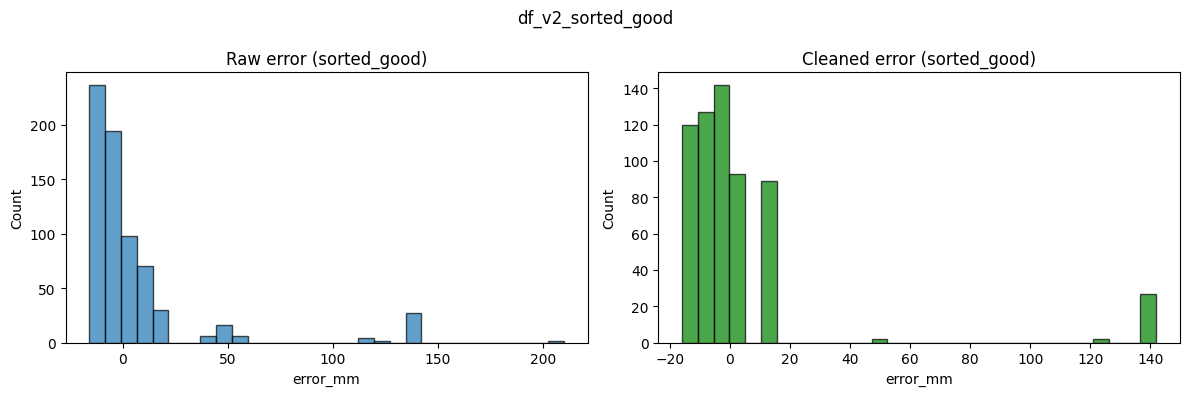

In [74]:
# Histograms: raw and cleaned error (sorted_good)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram_raw(df_v2_good, value_col="error_mm", bins=30, ax=axes[0], title="Raw error (sorted_good)")
plot_histogram_cleaned(df_v2_good, value_col="error_mm", n_std=2.0, bins=30, ax=axes[1], title="Cleaned error (sorted_good)")
plt.suptitle("df_v2_sorted_good")
plt.tight_layout()
plt.show()

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


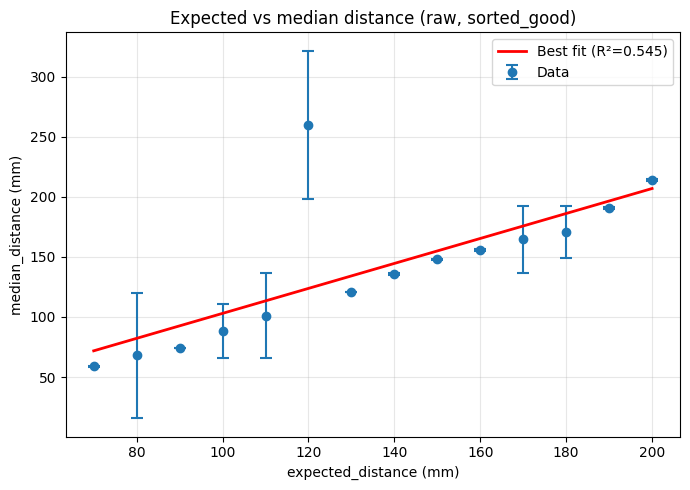

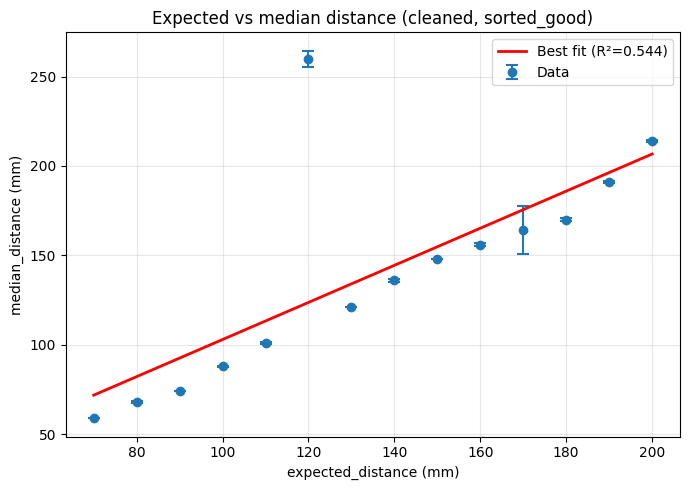

sorted_good (raw): slope=1.039, intercept=-0.865, R²=0.545
sorted_good (cleaned): slope=1.037, intercept=-0.699, R²=0.544


In [75]:
# Expected vs actual (sorted_good) - using all registers (already filtered to correct ones)
stats_good_raw = get_stats(df_v2_good, register=None)
df_v2_good_cleaned = remove_outliers_per_trial(df_v2_good, n_std=2.0)
stats_good_cleaned = get_stats(df_v2_good_cleaned, register=None)
plot_expected_vs_actual(stats_good_raw, y_col="median_distance", y_err_col="std_distance",
                        title="Expected vs median distance (raw, sorted_good)")
plt.show()
plot_expected_vs_actual(stats_good_cleaned, y_col="median_distance", y_err_col="std_distance",
                        title="Expected vs median distance (cleaned, sorted_good)")
plt.show()
for name, s in [("raw", stats_good_raw), ("cleaned", stats_good_cleaned)]:
    r = regression_stats(s)
    if r:
        print(f"sorted_good ({name}): slope={r['slope']:.3f}, intercept={r['intercept']:.3f}, R²={r['r_squared']:.3f}")

C:\Users\caden\AppData\Local\Temp\ipykernel_33156\3671667161.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(keep_inliers)


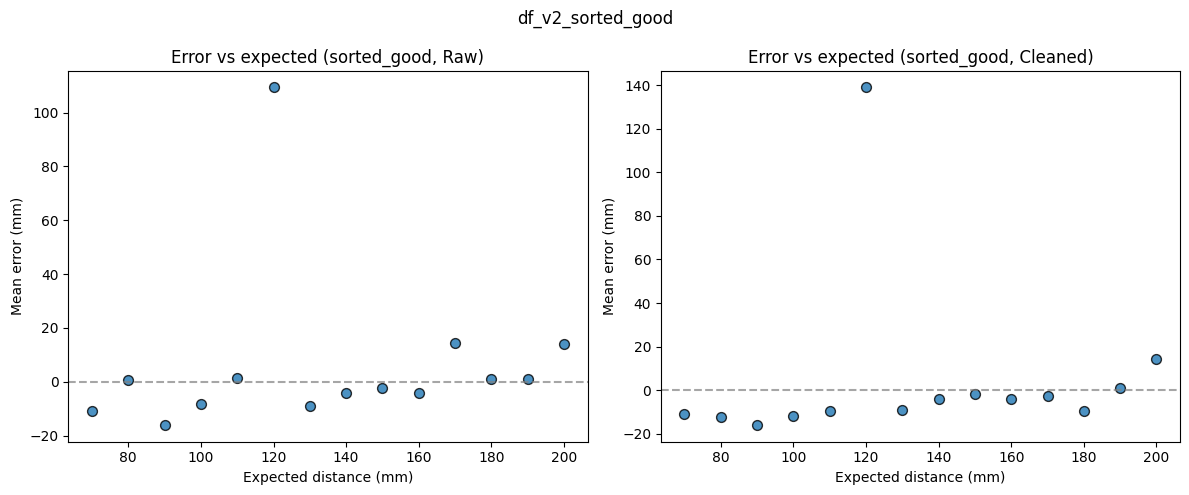

In [76]:
# --- Error pipeline (df_v2_sorted_good) ---
stats_good_err = get_stats(df_v2_good, register=None)
stats_good_err_cleaned = get_stats(remove_outliers_per_trial(df_v2_good, n_std=2.0), register=None)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, s, label in [(axes[0], stats_good_err, "Raw"), (axes[1], stats_good_err_cleaned, "Cleaned")]:
    ax.scatter(s["expected_distance"], s["mean_error"], alpha=0.8, edgecolors="k", s=50)
    ax.axhline(0, color="gray", linestyle="--", alpha=0.7)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Mean error (mm)")
    ax.set_title(f"Error vs expected (sorted_good, {label})")
plt.suptitle("df_v2_sorted_good")
plt.tight_layout()
plt.show()

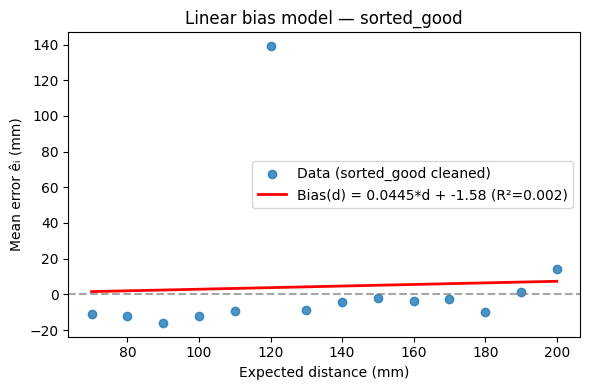

Bias (sorted_good): a = 0.0445, b = -1.58 mm, R² = 0.002


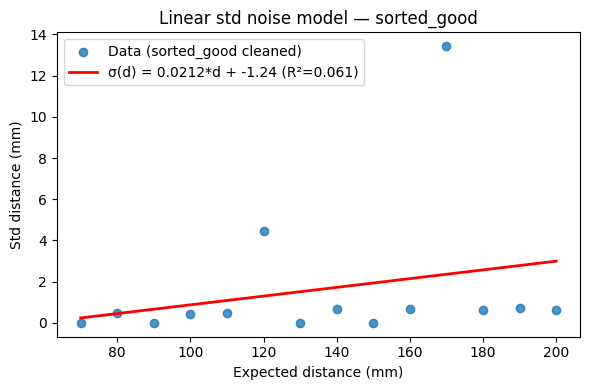

Std (sorted_good): c = 0.0212, d_const = -1.24 mm, R² = 0.061


In [77]:
# Linear bias and std (sorted_good)
fit_bias_good = plot_linear_bias(stats_good_err_cleaned, label="sorted_good cleaned")
plt.title("Linear bias model — sorted_good")
plt.tight_layout()
plt.show()
if fit_bias_good:
    print(f"Bias (sorted_good): a = {fit_bias_good['a']:.4f}, b = {fit_bias_good['b']:.2f} mm, R² = {fit_bias_good['r_squared']:.3f}")

fit_std_good = plot_linear_std(stats_good_err_cleaned, label="sorted_good cleaned")
plt.title("Linear std noise model — sorted_good")
plt.tight_layout()
plt.show()
if fit_std_good:
    print(f"Std (sorted_good): c = {fit_std_good['c']:.4f}, d_const = {fit_std_good['d_const']:.2f} mm, R² = {fit_std_good['r_squared']:.3f}")

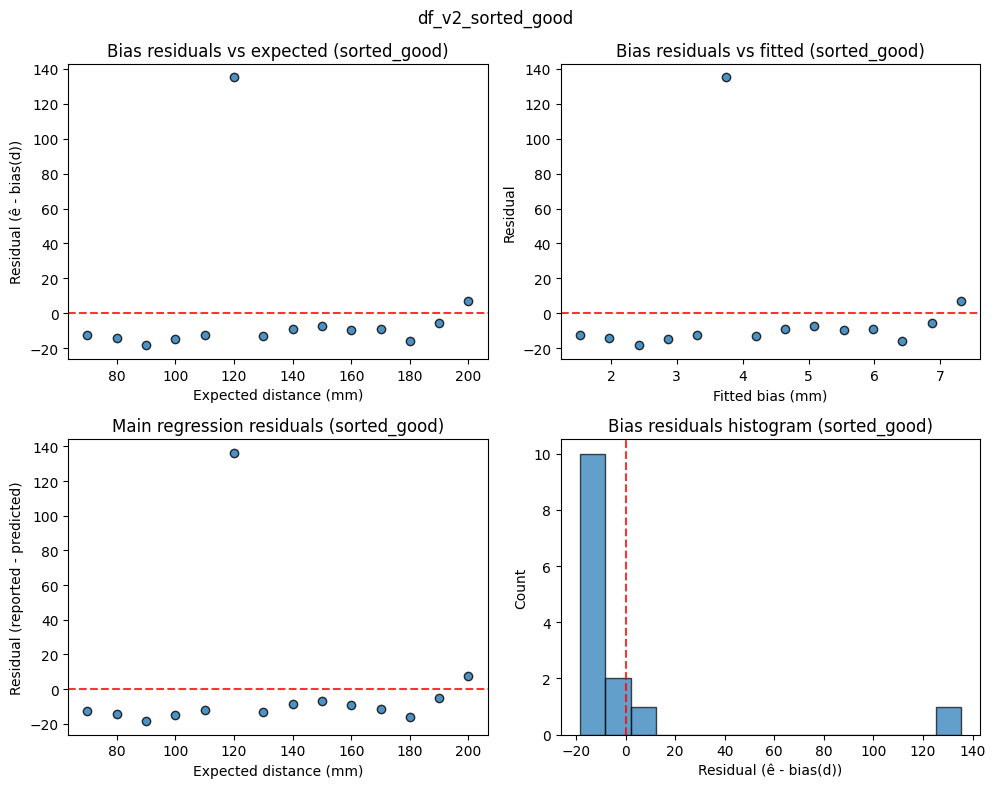

In [78]:
# Residual visualization (sorted_good)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
if fit_bias_good:
    ax = axes[0, 0]
    ax.scatter(fit_bias_good["x"], fit_bias_good["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (ê - bias(d))")
    ax.set_title("Bias residuals vs expected (sorted_good)")
if fit_bias_good:
    ax = axes[0, 1]
    fitted_b = fit_bias_good["a"] * fit_bias_good["x"] + fit_bias_good["b"]
    ax.scatter(fitted_b, fit_bias_good["residuals"], alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Fitted bias (mm)")
    ax.set_ylabel("Residual")
    ax.set_title("Bias residuals vs fitted (sorted_good)")
r_main_good = regression_stats(stats_good_cleaned, y_col="median_distance")
if r_main_good is not None:
    pred = r_main_good["slope"] * stats_good_cleaned["expected_distance"] + r_main_good["intercept"]
    res_main = stats_good_cleaned["median_distance"] - pred
    ax = axes[1, 0]
    ax.scatter(stats_good_cleaned["expected_distance"], res_main, alpha=0.8, edgecolors="k")
    ax.axhline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Expected distance (mm)")
    ax.set_ylabel("Residual (reported - predicted)")
    ax.set_title("Main regression residuals (sorted_good)")
if fit_bias_good:
    ax = axes[1, 1]
    ax.hist(fit_bias_good["residuals"], bins=15, edgecolor="black", alpha=0.7)
    ax.axvline(0, color="red", linestyle="--", alpha=0.8)
    ax.set_xlabel("Residual (ê - bias(d))")
    ax.set_ylabel("Count")
    ax.set_title("Bias residuals histogram (sorted_good)")
plt.suptitle("df_v2_sorted_good")
plt.tight_layout()
plt.show()